# ***AnoGAN Pytorch Train Guidebook***

# Written By Seung Hun Han Written In Dec/11/2022 Email: andrewhan@korea.ac.kr

### Purpose of this notebook is to guide you through the process of using CIFAR10 Dataset to train AnoGAN. 

### AnoGAN, developed for Image Anomaly Detection Task, trains Generator and Discriminator whose tasks are to mimic Normal images and successfully classify fake/real images, respectively.


## Work Flow of the Training Process

1. Define Car images as normal images (which is labelled '1' in the dataset)
2. Define images other than care are defined as abnormal images
3. Train Deep Convolutional GAN only with a normal dataset
4. Using the generator and discriminator trained in #3, train latent vector that best fits the input images (Here, a dataset is compriseed of both normal Abnormal images)
5. Calculate anomaly score, which is a weighted sum of discrimination and residual loss.
6. Based on an assessment on anomaly score distribution for normal and abnormal images, define threshold that would classifies two groups the best.

Ideally, under the premise that DCGAN was well trained in Step 3, the anomaly score of normal images should be distinctively lower than that of abnormal images.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import CIFAR10
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torchvision.utils import make_grid

sys.path.append('./AnoGAN')

from model import *
from utils import custom_data,weights_init,display_image,transform_data

### Initial Setup to prepare dataset and models

In [3]:
latent_dim=128
is_color=True
lr=0.0001
batchsize=128
image_size=64
epochs=200

transform=transform_data(image_size)

Trainset will only be comprised of 'normal' images. Since some of the normal images will used for anomaly score calculation, make sure to divide normal images in train set into certain ratio.

In [3]:
train_dataset = CIFAR10(root='../data/', train=True, download=True)

x_train=torch.ByteTensor(train_dataset.data[torch.tensor(train_dataset.targets)==1])
x_train_normal, x_valid_normal = x_train.split((int(len(x_train) * 0.8)), dim=0)

y_train=torch.ByteTensor(train_dataset.targets)[torch.tensor(train_dataset.targets)==1]
y_traiin_normal, y_valid_normal = y_train.split((int(len(y_train) * 0.8)), dim=0)

data=custom_data(x_train_normal,y_traiin_normal,transform=transform)
train_loader_normal = DataLoader(data, batch_size=batchsize, shuffle=True)

val_dataset = CIFAR10(root='../data/', train=False, download=True)

x_train_ab=torch.ByteTensor(train_dataset.data[torch.tensor(train_dataset.targets)!=1])
y_train_ab=torch.ByteTensor(train_dataset.targets)[torch.tensor(train_dataset.targets)!=1]


device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


## Classifier Initial Method:

    Args:
        device: cuda or cpu
        latent_dim: Dimension of Latent Vector Z which is computed into generator to produce fake image
        img_size: Size of image being computed
        is_color: Configures number of channel 3 for colors 1 for grey

## train_G_D function:

    Purpose 'Fit Generator and Discriminator only using normal dataset'

        Args:
            Train_loader: DataLoader which should cosist of normal (with no anomaly) dataset
            lr: Learning rate for discriminator and generator
            latent_dim: Dimension of Latent Vector Z which is computed into generator to produce fake image
            img_size: Size of image being computed
            is_color: Configures number of channel 3 for colors 1 for grey
            bias: add bias
            Epochs: Epochs for training
            g_epochs: Number of generator backpropagation per one epoch. This setup is to prevent underfitting of generator compared to discriminator.
            sample_size: Number of images which will be sampled to create training progress image 
            Verbose: Print iteration progress
        Returns:
            Trained Generator
            Trained Discriminator

## latent_mapping function:

    Purpose: 'Train a latent vector that can be mapped to the computed image and calculate anomaly score' 

        Args:
            test_loader: DataLoader which should cosist of normal and abnormal dataset
            lr: Learning rate for latent vector optimizer
            alpha: Weight used to calculate anomaly score.
            D: Trained discriminator. If undefined, discriminator trained in train_G_D will be used, if ever been called before.
            D: Trained generator. If undefined, generator trained in train_G_D will be used, if ever been called before.
            Iteration: Number of backpropagation to optimize one single image

        Returns:

            Original image vector in the test loader
            Original label vector in the test loader
            Fully trained latent vector collections
            Anomaly score for each images

In [4]:
from train import train
C=train(device,latent_dim,is_color,image_size)

In [ ]:
g,d=C.train_G_D(train_loader=train_loader_normal,g_epochs=3,lr=lr,
            verbose=True,epochs=epochs)

### Generator and Discriminator Training Result after 200 epochs

Even with simple convolution layers, GAN managed to successfully mimic features of normal images.

![Fully_trained](train_img/epoch_199_train.png)

Train Set should consist of both normal and abnormal images

Due to limited computational power, test dataset has been batched with 64 images. Ideally, the batch size should be 'one' in order to fully train latent vector of an individual images in a test set.

In [100]:
x_val=torch.tensor(val_dataset.data)
y_val=torch.tensor(val_dataset.targets)

x_test=torch.cat([x_train_ab,x_valid_normal,x_val],dim=0)
y_test=torch.cat([y_train_ab,y_valid_normal,y_val],dim=0)

data_test=custom_data(x_test,y_test,transform=transform)
test_loader = DataLoader(data_test, batch_size=1, shuffle=True,drop_last=True)

Any pretrained Generator and Discriminator can be used for the following process as long as latent vector size of discriminator and function input are same.

## ** Pretrained model weight available in 
### ./model_saves/Discriminator_best.pt and ./model_saves/Generator_best.pt

In [10]:
G = generator(latent_dim=latent_dim, last_dim=image_size, is_color=is_color, bias=False).to(device)
D = Discriminator(imgsize=image_size, is_color=is_color, bias=False).to(device)

In [11]:
G.load_state_dict(torch.load('./model_saves/permanent/Generator_best_mnist.pt'))
D.load_state_dict(torch.load('./model_saves/Discriminator_best_mnist.pt'))

<All keys matched successfully>

In [ ]:
xx,yy,z,loss=C.latent_mapping(test_loader,alpha=0.5,D=D,G=G,iteration=400)

![Fully_trained_latent](test_imgs/test_img_4.png)

Since different classes of images were trained in same batch, they all seem to resemble shape of a car.

Since DCGAN was trained well, difference between original image and generated image of a normal input are pretty smaller than that of an abnormal input.

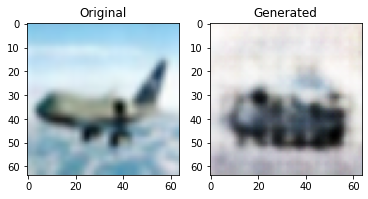

In [64]:
from utils import plot_test

z_sampled=torch.tensor(z[0][100],dtype=torch.float,device=device).reshape(1,latent_dim,1,1)

new_xx=torch.tensor(xx[0],dtype=torch.float)
gen_vec=G(z_sampled)
fig, axs = plt.subplots(1, 2)

axs[0].title.set_text('Original')
axs[1].title.set_text('Generated')

axs[0].imshow(make_grid(new_xx[100],normalize=True,padding=3).permute((1,2,0)))
axs[1].imshow(make_grid(gen_vec.detach().cpu(),normalize=True,padding=3).permute((1,2,0)))

On the other hand, latent vector was not trained well when abnormal image is computed as the target which implicates high anomaly score.

Text(0.5, 1.0, 'Generated')

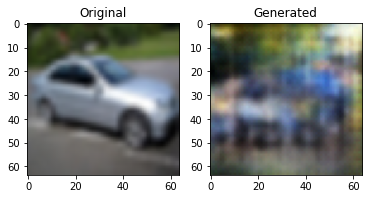

In [99]:
z_sampled=torch.tensor(z[0][7],dtype=torch.float,device=device).reshape(1,latent_dim,1,1)

new_xx=torch.tensor(xx[0],dtype=torch.float)
gen_vec=G(z_sampled)
fig, axs = plt.subplots(1, 2)

axs[0].imshow(make_grid(new_xx[7],normalize=True,padding=3).permute((1,2,0)))
axs[0].set_title('Original')

axs[1].imshow(make_grid(gen_vec.detach().cpu(),normalize=True,padding=3).permute((1,2,0)))
axs[1].set_title('Generated')

Latent vector trained well (both have distinct shape of cars) when normal image (car) is computed as the target which implicates low anomaly score.

CIFAR10 dataset is certainly not suitable for anomaly detection task since normal images seldomly have common feature (Different brand, shape, color). 

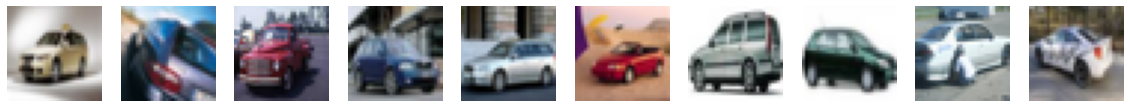

In [85]:
sampled_cars=x_train_normal[100:110]

fig, axs = plt.subplots(1, 10,figsize=(20,20))

for i in range(10):

    axs[i].imshow(sampled_cars[i])
    axs[i].axis('off')

Final Classification result is not provided in this notebook due to limited computational power. For further experiment, simply obtain anomaly score for each images and classify based on configured threshold (that is if anomaly score of an image is smaller than the threshold, classify it as 'normal' and vice versa) 